https://www.kaggle.com/shebrahimi/financial-distress

Fit a scaler on the training set and apply it directly to the test set. Only apply SMOTE to the training set. If the performance of the classifier on the minority class is bad, try ROC AUC curve in which the decision boundary is adjusted. 

In [3]:
clusters = tuple([[0, 5], [1, 7, 35, 45], [2, 12, 13, 46, 48], [3], [4], [6], [8, 24], [9, 80], [10], [11], [14, 34], [15, 51], [16, 33], [17, 19], [18], [20], [21], [22, 49], [23], [25], [26], [27], [28, 32], [29], [30], [31], [36], [37], [38], [39], [40], [41, 54], [42], [43], [44], [47], [50], [52], [53], [55], [56], [57, 58], [59], [60], [61], [62], [63], [64], [65], [66], [67, 74, 75], [68], [69], [70], [71], [72], [73], [76], [77], [78], [81], [82]])
useful = [tuple(c) for c in clusters if len(c) > 1]
useful.sort(key=len, reverse = True)
useful

[(2, 12, 13, 46, 48),
 (1, 7, 35, 45),
 (67, 74, 75),
 (0, 5),
 (8, 24),
 (9, 80),
 (14, 34),
 (15, 51),
 (16, 33),
 (17, 19),
 (22, 49),
 (28, 32),
 (41, 54),
 (57, 58)]

In [2]:
import numpy as np
import pandas as pd
import sys
sys.path.insert(1, '/Users/chengpeng/Desktop/Research/STAT/CIBer')
import comonotonic as cm
import os
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import copy
import utils
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
import ensemble_ciber as ec
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn import tree
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import SMOTENC
import xlsxwriter
from sklearn.metrics import confusion_matrix, log_loss

In [3]:
df = pd.read_csv("Financial Distress.csv")
df['Financial Distress'].values[df['Financial Distress'].values > -0.5] = 0
df['Financial Distress'].values[df['Financial Distress'].values <= -0.5] = 1
df['x80'] = df['x80']-1
df['Financial Distress'] = df['Financial Distress'].astype(int)
distress = df['Financial Distress']
df = df.drop(columns=['Company','Time','Financial Distress'])
df['Financial Distress'] = distress
colnames = [('X'+str(i)) for i in range(df.shape[1]-1)]
colnames.append('Y')
df.columns = colnames

In [4]:
categorical = [79]
cont_col = [i for i in range(79)]+[i for i in range(80,83)]
discrete_feature_val = {79:37}

In [5]:
df_train, df_test = train_test_split(df, test_size=0.3, stratify=df[['Y']])

In [6]:
scaler = preprocessing.StandardScaler()
scale_col_name = ["X"+str(i) for i in cont_col]
df_train[scale_col_name] = scaler.fit_transform(df_train[scale_col_name])
reduced_df_train = utils.outlier_removal(df_train, cont_col)
df_test[scale_col_name] = scaler.transform(df_test[scale_col_name])

<ipython-input-6-88a3eb6502cd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[scale_col_name] = scaler.fit_transform(df_train[scale_col_name])
/Users/chengpeng/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
<ipython-input-6-88a3eb6502cd>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

In [7]:
# reduced_df_train stands for the dataframe for training after outlier removal
x_train = reduced_df_train.iloc[:,:-1].to_numpy()
y_train = reduced_df_train.iloc[:,-1].to_numpy()
smote_nc = SMOTENC(categorical_features=[79], sampling_strategy = "all", random_state=0)
x_train_synthetic, y_train_synthetic = smote_nc.fit_resample(x_train, y_train)
x_test = df_test.iloc[:,:-1].to_numpy()
y_test = df_test.iloc[:,-1].to_numpy()

In [8]:
ciber = cm.clustered_comonotonic(x_train_synthetic,y_train_synthetic,
                                 discrete_feature_val,cont_col,categorical, 
                                 0.92, None, corrtype='spearman',
                                 discrete_method='mdlp')
ciber.run()
ciber_predict = ciber.predict(x_test)
ciber_proba = ciber.predict_proba(x_test)
print(classification_report(y_test,ciber_predict))
print(utils.informational_loss(ciber_proba,y_test))

              precision    recall  f1-score   support

           0       0.98      0.95      0.97      1061
           1       0.28      0.46      0.35        41

    accuracy                           0.94      1102
   macro avg       0.63      0.71      0.66      1102
weighted avg       0.95      0.94      0.94      1102

1.3491711251184029


In [13]:
log_loss(y_test, ciber_proba)

0.897155321843742

In [17]:
clusters = [[0, 5], [1, 7, 35, 45], [2, 12, 13, 46, 48], [3], [4], [6], [8, 24], [9, 80], [10], [11], [14, 34], [15, 51], [16, 33], [17, 19], [18], [20], [21], [22, 49], [23], [25], [26], [27], [28, 32], [29], [30], [31], [36], [37], [38], [39], [40], [41, 54], [42], [43], [44], [47], [50], [52], [53], [55], [56], [57, 58], [59], [60], [61], [62], [63], [64], [65], [66], [67, 74, 75], [68], [69], [70], [71], [72], [73], [76], [77], [78], [81], [82]]
useful_clusters = [c for c in clusters if len(c) > 1]

/home/r7user5/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:4569: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,
/home/r7user5/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/r7user5/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:4569: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

/home/r7user5/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:4569: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,
/home/r7user5/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/r7user5/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:4569: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

IndexError: list index out of range

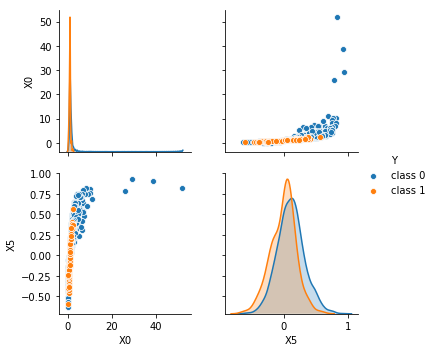

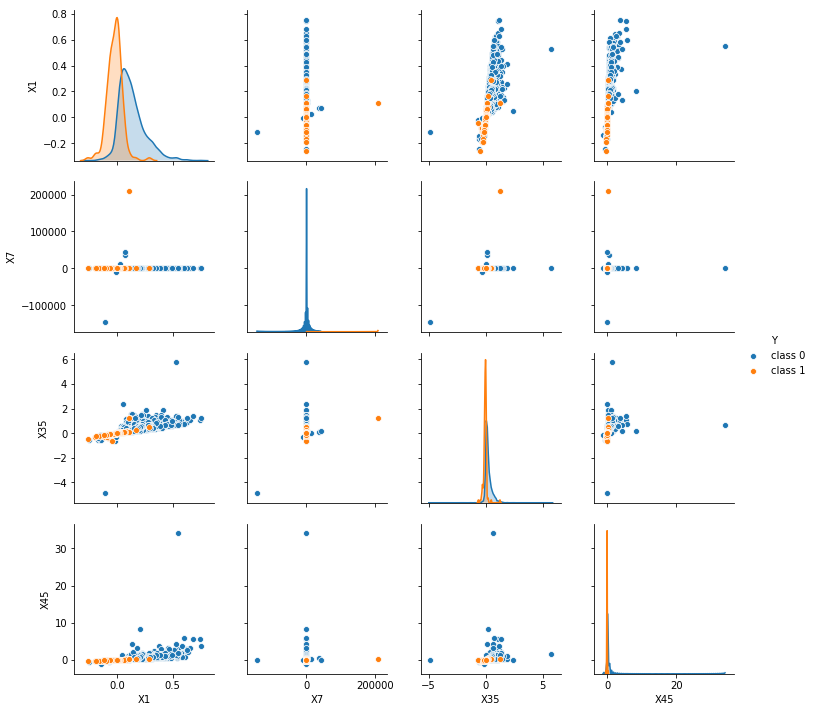

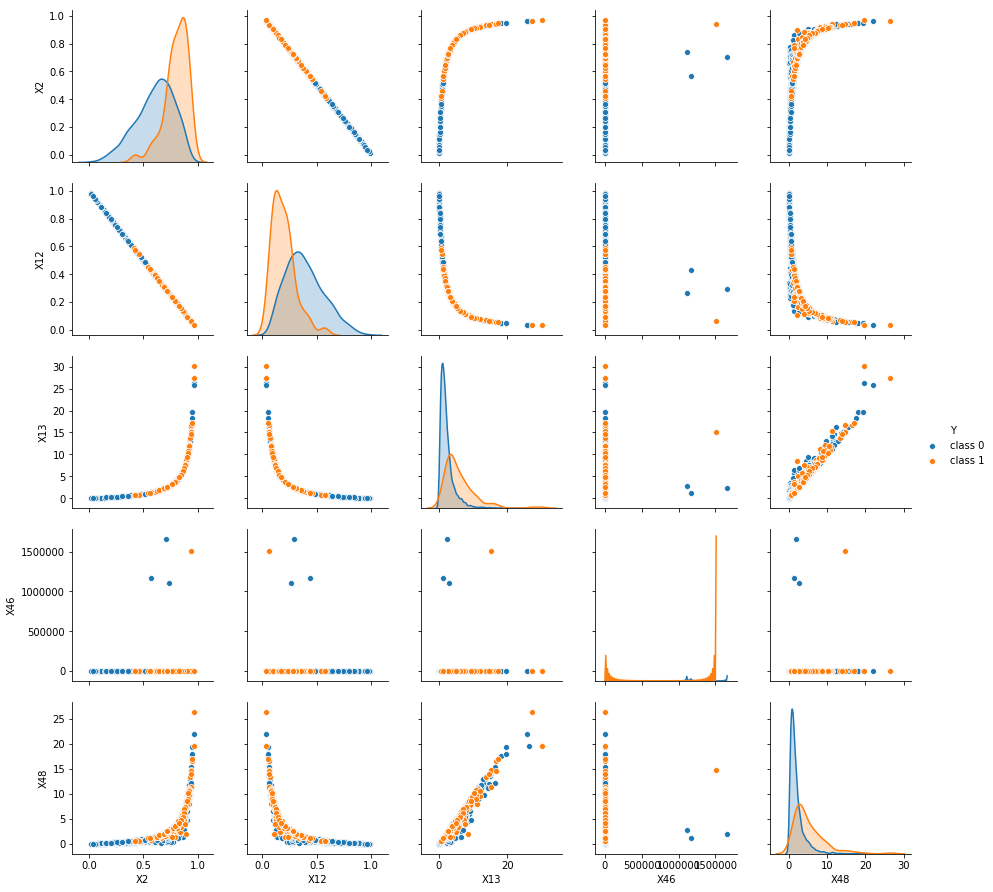

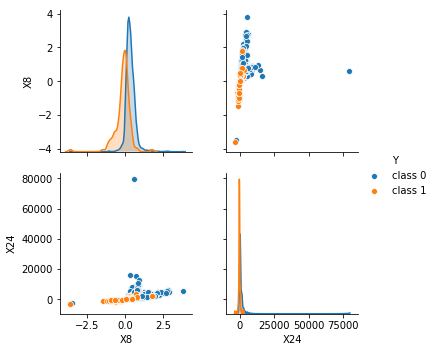

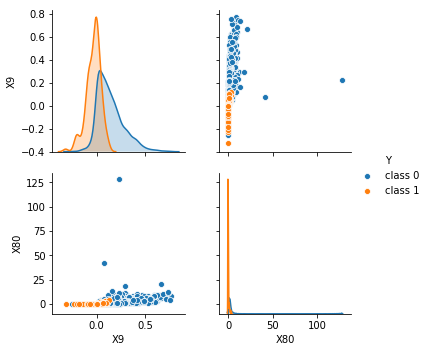

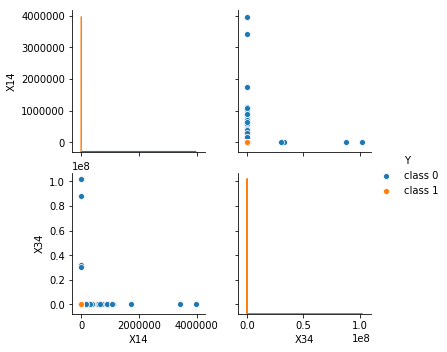

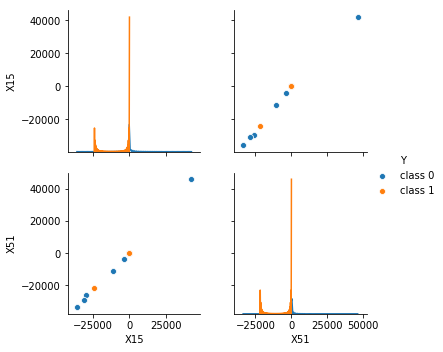

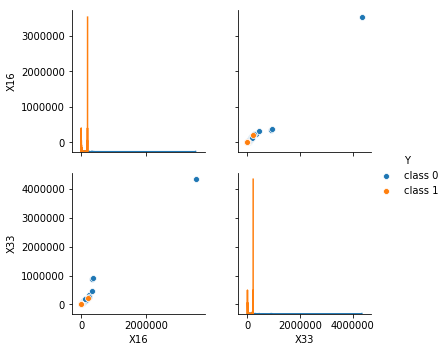

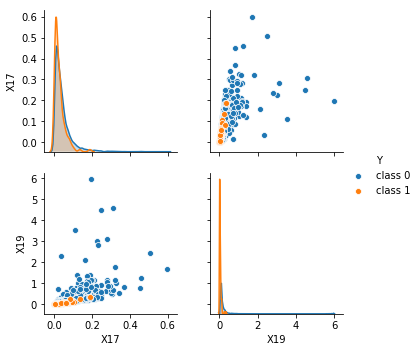

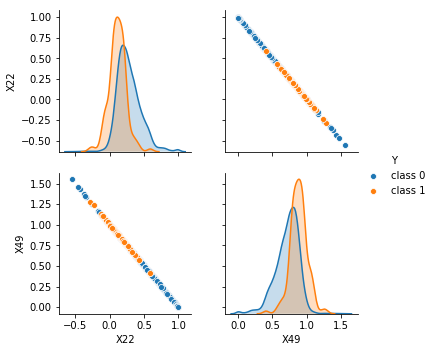

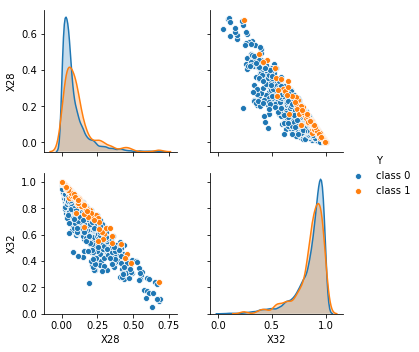

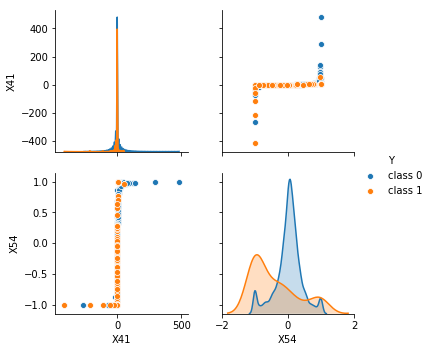

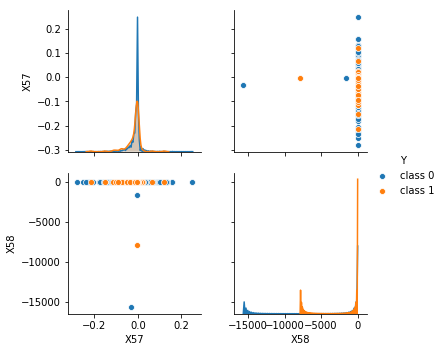

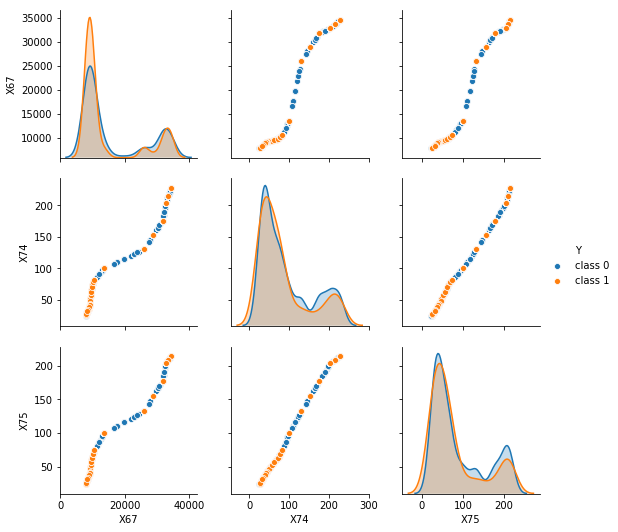

In [18]:
for i in range(15):
    df_4_plot = df.iloc[:,useful_clusters[i]+[83]]
    df_4_plot["Y"].replace({0:'class 0', 1:'class 1'}, inplace = True)
    plot = sns.pairplot(df_4_plot,hue='Y')
    plot.savefig("cluster"+str(i+1)+".png", dpi = 800)

Looking at the class-wise distribution of each variable in the cluster, the smaller the class-wise distributions differs, the lower the power of judgement of the Naive Bayes, the more competitive of CIBer.

In [11]:
gaussian_nb = GaussianNB()
gaussian_nb.fit(x_train_synthetic, y_train_synthetic)
gaussian_predict = gaussian_nb.predict(x_test)
print(classification_report(y_test, gaussian_predict))

              precision    recall  f1-score   support

           0       1.00      0.60      0.75      1061
           1       0.08      0.93      0.15        41

    accuracy                           0.61      1102
   macro avg       0.54      0.76      0.45      1102
weighted avg       0.96      0.61      0.73      1102



In [12]:
print(confusion_matrix(y_test, gaussian_predict))

[[637 424]
 [  3  38]]


In [16]:
xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(x_train_synthetic,y_train_synthetic)
xgb_predict = xgb_clf.predict(x_test)
xgb_proba = xgb_clf.predict_proba(x_test)
print(classification_report(y_test, xgb_predict))
print(log_loss(y_test, xgb_proba))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97      1061
           1       0.33      0.37      0.34        41

    accuracy                           0.95      1102
   macro avg       0.65      0.67      0.66      1102
weighted avg       0.95      0.95      0.95      1102

0.16125900002508575


In [17]:
utils.informational_loss(xgb_proba, y_test)

0.23264755731367281

In [19]:
rf_clf = RandomForestClassifier()
rf_clf.fit(x_train_synthetic,y_train_synthetic)
rf_predict = rf_clf.predict(x_test)
rf_proba = rf_clf.predict_proba(x_test)
print(classification_report(y_test, rf_predict))
print(log_loss(y_test,rf_proba))

/home/r7user5/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1061
           1       0.31      0.29      0.30        41

    accuracy                           0.95      1102
   macro avg       0.64      0.63      0.64      1102
weighted avg       0.95      0.95      0.95      1102

0.19400482737214883


In [16]:
print(confusion_matrix(y_test, rf_predict))

[[1024   37]
 [  30   11]]


In [21]:
DT_clf = tree.DecisionTreeClassifier()
DT_clf.fit(x_train_synthetic, y_train_synthetic)
DT_predict = DT_clf.predict(x_test)
DT_proba = DT_clf.predict_proba(x_test)
print(classification_report(y_test, DT_predict))
print(log_loss(y_test, DT_proba))

              precision    recall  f1-score   support

           0       0.97      0.94      0.96      1061
           1       0.17      0.29      0.21        41

    accuracy                           0.92      1102
   macro avg       0.57      0.62      0.58      1102
weighted avg       0.94      0.92      0.93      1102

2.7894293095708274


In [18]:
print(confusion_matrix(y_test, DT_predict))

[[1001   60]
 [  22   19]]


In [22]:
svm = SVC(probability=True)
svm.fit(x_train_synthetic, y_train_synthetic)
svm_predict = svm.predict(x_test)
svm_proba = svm.predict_proba(x_test)
print(classification_report(y_test, svm_predict))
print(log_loss(y_test, svm_proba))

/home/r7user5/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


              precision    recall  f1-score   support

           0       0.98      0.94      0.96      1061
           1       0.27      0.59      0.37        41

    accuracy                           0.93      1102
   macro avg       0.63      0.76      0.66      1102
weighted avg       0.96      0.93      0.94      1102

0.17932853846782099


In [20]:
print(confusion_matrix(y_test, svm_predict))

[[885 176]
 [ 10  31]]


In [21]:
lr = LogisticRegression()
lr.fit(x_train_synthetic, y_train_synthetic)
lr_predict = lr.predict(x_test)
print(classification_report(y_test, lr_predict))
print(roc_auc_score(y_test, lr_predict))

/home/r7user5/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

           0       0.99      0.86      0.92      1061
           1       0.19      0.83      0.30        41

    accuracy                           0.86      1102
   macro avg       0.59      0.84      0.61      1102
weighted avg       0.96      0.86      0.90      1102

0.8444173697156386


In [22]:
print(confusion_matrix(y_test, lr_predict))

[[912 149]
 [  7  34]]


In [23]:
from sklearn.metrics import roc_curve
ciber_probs = ciber.predict_proba(x_test)[:,1]
ciber_fpr, ciber_tpr, _ = roc_curve(y_test, ciber_probs)
ciber_auc = roc_auc_score(y_test, ciber_probs)

nb_probs = gaussian_nb.predict_proba(x_test)[:,1]
nb_fpr, nb_tpr, _ = roc_curve(y_test, nb_probs)
nb_auc = roc_auc_score(y_test, nb_probs)

xgb_probs = xgb_clf.predict_proba(x_test)[:,1]
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_probs)
xgb_auc = roc_auc_score(y_test, xgb_probs)

rf_probs = rf_clf.predict_proba(x_test)[:,1]
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
rf_auc = roc_auc_score(y_test, rf_probs)

DT_probs = DT_clf.predict_proba(x_test)[:,1]
DT_fpr, DT_tpr, _ = roc_curve(y_test, DT_probs)
DT_auc = roc_auc_score(y_test, DT_probs)

svm_probs = svm.predict_proba(x_test)[:,1]
svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_probs)
svm_auc = roc_auc_score(y_test, svm_probs)

lr_probs = lr.predict_proba(x_test)[:,1]
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

In [26]:
base_probs = [0 for _ in range(len(y_test))]
base_fpr, base_tpr, _ = roc_curve(y_test, base_probs)

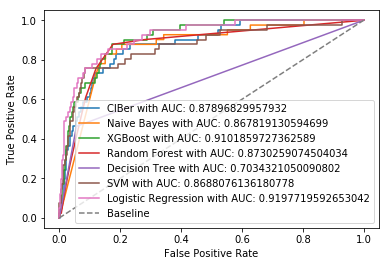

In [37]:
plt.plot(ciber_fpr, ciber_tpr, label='CIBer with AUC: ' + str(ciber_auc))
plt.plot(nb_fpr, nb_tpr, label='Naive Bayes with AUC: ' + str(nb_auc))
plt.plot(xgb_fpr, xgb_tpr, label='XGBoost with AUC: ' + str(xgb_auc))
plt.plot(rf_fpr, rf_tpr, label='Random Forest with AUC: ' + str(rf_auc))
plt.plot(DT_fpr, DT_tpr, label='Decision Tree with AUC: ' + str(DT_auc))
plt.plot(svm_fpr, svm_tpr, label='SVM with AUC: ' + str(svm_auc))
plt.plot(lr_fpr, lr_tpr, label='Logistic Regression with AUC: ' + str(lr_auc))
plt.plot(base_fpr, base_tpr, linestyle='--', label='Baseline')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.savefig('ROC Curve.png', format='png', dpi=1200)

<Figure size 432x288 with 0 Axes>